<a href="https://colab.research.google.com/github/JDS289/DNNs/blob/main/trimmedA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Neural Networks - First Assignment 2025
## A: *Reparametrization*: the effect of parameter scaling


In this part of the exercise you will explore the behaviour of simple models (linear models and one-hidden layer ReLU networks) under gradient descent.

If you follow along, the take home messages will be:
1. In neural networks, the same function can be represented by several different settings of the parameters. This is called reparametrization-invariance.
2. Differently parametrized neural networks behave differently under gradient descent, and this difference may lead to qualitatively different solutions.
3. Initialization of parameters is crucially important. Starting from different initialization can lead to qualitatively different solutions, too.

# Preliminaries



We will start by creating a linear model, with 1D input and 1D output, using the `pytorch` layer type `Linear`. We will only need a single layer like this, with input and output dimension both set to 1. (For reproducibility, I set the `torch` random seed in each cell.)

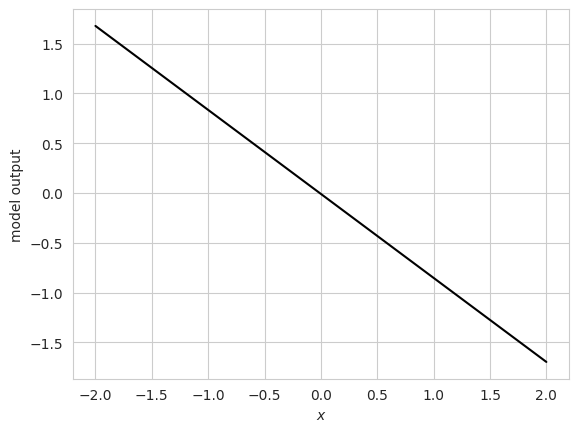

In [7]:
import torch
from torch.nn import Linear, Parameter

torch.manual_seed(1337)
lin = Linear(1, 1)

# choose a grid of input points to evaluate the model at
x_grid = torch.linspace(-2, 2, 200)[:, None]
predictions = lin(x_grid)

from matplotlib import colors, cm, pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

plt.plot(x_grid, predictions.detach(), 'k');
plt.xlabel('$x$');
plt.ylabel('model output');

Remarks:
* Notice how I used `[:, None]` to reshape the output of linspace. This adds an extra dimension to the tensor, which was important since the linear layer expects `num_datapoints×num_input_dimensions` shaped input. Indexing in pytorch works very similarly to numpy, if you are not familiar with it, I encourage you to check out online tutorials on numpy and torch indexing.
* We evaluated the model by simply calling `lin(x_grid)`. The output has a computational graph attached, for subsequent backpropagation. In order to plot the result, we have to detach the graph, by calling the `detach` method.


# Question A.1: Reparametrization


We will now create an equivalent model to our favourite `lin`. One that uses a different parametrization, but is still a linear model. Our original linear model is described as follows:

$$
f(x ; w_1, b_1) = w_1x + b_1
$$

Now, we will consider a slightly different, but equivalent model:

$$
g(x; w_2, b_2) = c \cdot w_2 x + b_2,
$$

where $c\neq0$ is a constant (not a trainable parameter). One can see that by setting $w_2 = \frac{w_1}{c}$ and $b_2 = b_1$, the two models implement the same linear function.

Your task is to create a function that takes a linear layer that implements $f$, and outputs another pytorch model that implements $g$, setting $g$'s parameters $w_2, b_2$ so that at creation, the two models give the same output.

Tips:
* if/when copying layers, use `deepcopy` to ensure that you don't accidentally tie the parameters of the new layer and the original together.
* you can use a `torch.nn.Sequential` to compose layers. This task is easiest to solve by creating new network with two `Linear` layers.
* make sure the new model has only two trainable parameters (i.e. $c$ does not end up a trainable parameter). You can make a parameter fixed by setting `param.requires_grad=False`.
* you can use `lin.weight` and `lin.bias`
* when manipulating model weights directly, I suggest using `torch.no_grad`

## Answer A.1

Please complete the code blocks below.

In [10]:
from copy import deepcopy

@torch.no_grad()
def reparametrise_linear(linear_layer, c=2.0):
    """Takes a Linear pytorch layer, and returns an equivalent network."""

    layer_copy = deepcopy(linear_layer)
    layer_copy.weight /= c
    layer_copy.bias /= c  # this is required if layer_mult_c is applied after

    layer_mult_c = Linear(layer_copy.out_features, layer_copy.out_features, bias=False)
    layer_mult_c.weight = Parameter(c*torch.eye(layer_copy.out_features), requires_grad=False)

    return torch.nn.Sequential(layer_copy, layer_mult_c)

In [11]:
#here is a simple test that should successfully run
torch.manual_seed(1337)
model = Linear(1, 1)
model2 = reparametrise_linear(model, c=2.0)
assert torch.allclose(model(x_grid), model2(x_grid))

assert len([p for p in model.parameters() if p.requires_grad])==2
assert len([p for p in model2.parameters() if p.requires_grad])==2

# Question A.2: Plot the effect of a single gradient step



Your second task is to illustrate how a single gradient descent step changes our model's output, after we observe a single datapoint at $x=1, y=1$.

#### A.2.1.
Please fill out each of the incomplete lines commented as '## step n' below.
* For optimizer, please use SGD, no momentum, learning rate set to $0.05$
* for loss, please calculate (mean) squared error between the model's output at $x$ and the desired output $y$.

Use the `reparametrize_linear` the model from the previous task to create equivalent linear models, repeat the single gradient step experiment on each.

#### A.2.2.
Plot the results, and explain any differences between the reparametrised and original models' behaviour in the text box below.

####A.2.3.
Can you derive the effect of the gradient step analytically? You can use LaTeX to type it up if you'd like.

## Answer A.2

Please complete the code cells and add interpretation in the text cell below.

In [12]:
#note: if you import things for this cell, please do that here
from torch.optim import SGD
from torch.nn.functional import mse_loss

#here is the single training datapoint
x = torch.tensor([[1.0]])
y = torch.tensor([[1.0]])

def gradient_steps(model, x, y, x_test, lr, iterations, optimizer=SGD):
    """Performs the specified amount of SGD optimization steps on a model."""

    ##step 1: compute the prediction of the model on x_test before the step
    pred_before = model(x_test)
    preds_all = [pred_before.detach()]

    ## step 2: create an SGD optimizer
    optimizer = optimizer(model.parameters(), lr=lr)

    ## step 3: calculate the squared loss
    loss = torch.nn.MSELoss()

    for i in range(iterations):
        optimizer.zero_grad()
        loss(model(x), y).backward()  ## step 4: backpropagate
        optimizer.step()  ## step 5: take a step with the optimizer
        preds_all.append(model(x_test).detach())  ## step 6: calculate the predictions after the step

    return preds_all

def single_gradient_step(model, x, y, x_test=x_grid, lr=0.05):
    return gradient_steps(model, x, y, x_test, lr, iterations=1)

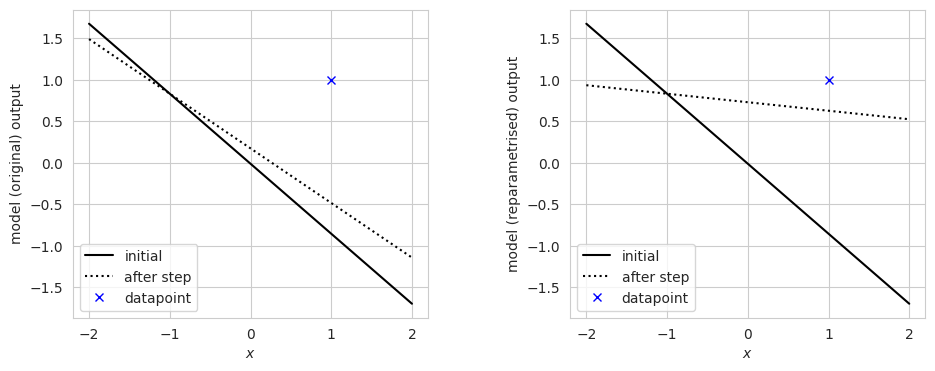

In [13]:
torch.manual_seed(1337)

lin = Linear(1, 1)
reparam = reparametrise_linear(lin, 2)

fig, axs = plt.subplots(ncols=2, figsize=(11, 4))
fig.subplots_adjust(wspace=0.4)

for ax, model, name in zip(axs, [lin, reparam], ["original", "reparametrised"]):
    pred_before, pred_after = single_gradient_step(model, x, y)
    ax.plot(x_grid, pred_before, 'k')
    ax.plot(x_grid, pred_after, 'k:')
    ax.plot(x, y, 'bx')
    ax.legend(['initial', 'after step','datapoint'], loc=3)
    ax.set_xlabel('$x$')
    ax.set_ylabel(f'model ({name}) output');

#### Interpretation

The reparametrised model seems to learn faster than the original.
More precisely:
$$
\text{Let } o(x) \text{ refer to the original (un-reparametrised) model,}
\\ \text{and }     r(x) \text{ to the reparametrised model.} ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
\\ o(x) = w_o x+b_o, ~~~~ r(x) = 2w_r x + 2b_r
\\ \text{(noting that initially } w_r = w_o/2 \text{ and } b_r=b_o/2 \text{)}
\\[0.3in]
\\ \Delta w_o ∝ \frac{\partial L(o)}{\partial w_o} = \frac{\partial (w_o+b_o-1)^2}{\partial w_o} = \frac{\partial (w_o^2+2w_o(b_o-1) + (b_o -1)^2)}{\partial w_o} = 2w_o + 2b_o -2
\\ \Delta b_o ∝ \frac{\partial L(o)}{\partial b_o} = \frac{\partial (w_o+b_o-1)^2}{\partial b_o} = \frac{\partial (b_o^2 + 2b_o(w_o-1) + (w_o-1)^2)}{\partial b_o} = 2b_o +2w_o -2
\\[0.3in]
\\ \Delta w_r ∝ \frac{\partial L(r)}{\partial w_r} = \frac{\partial (2w_r+2b_r-1)^2}{\partial w_r} = \frac{\partial (4w_r^2+4w_r(2b_r-1) + (2b_r -1)^2)}{\partial w_r} = 8w_r + 8b_r -4 = 4w_o +4b_o - 4
\\ \Delta b_r ∝ \frac{\partial L(r)}{\partial b_r} = \frac{\partial (2w_r+2b_r-1)^2}{\partial b_r} = \frac{\partial (4b_r^2 + 4b_r(2w_r-1) + (2w_1-1)^2)}{\partial b_r} = 8b_r + 8w_r -4 = 4b_o + 4w_o-4
$$

So the parameters in the reparametrised model are updated at twice the rate, and that's not including the extra doubling in $r(x)$. So in effect the reparametrised model learns at 4 (or, in general, $c^2$) times the original rate.

# Question A.3: Where does training converge?



Using the `reparametrise_linear` function below, create new versions of the `lin` model, with $c=2$ and $c=0.5$, respectively. Now, train each of these models on the $x=1, y=1$ datapoint using 1000 iterations of gradient descent with a learning rate of $0.01$.

Plot the solutions found, and explain what you see.

## Answer A.3

Please complete the code block below and add interpretation to the text cell.

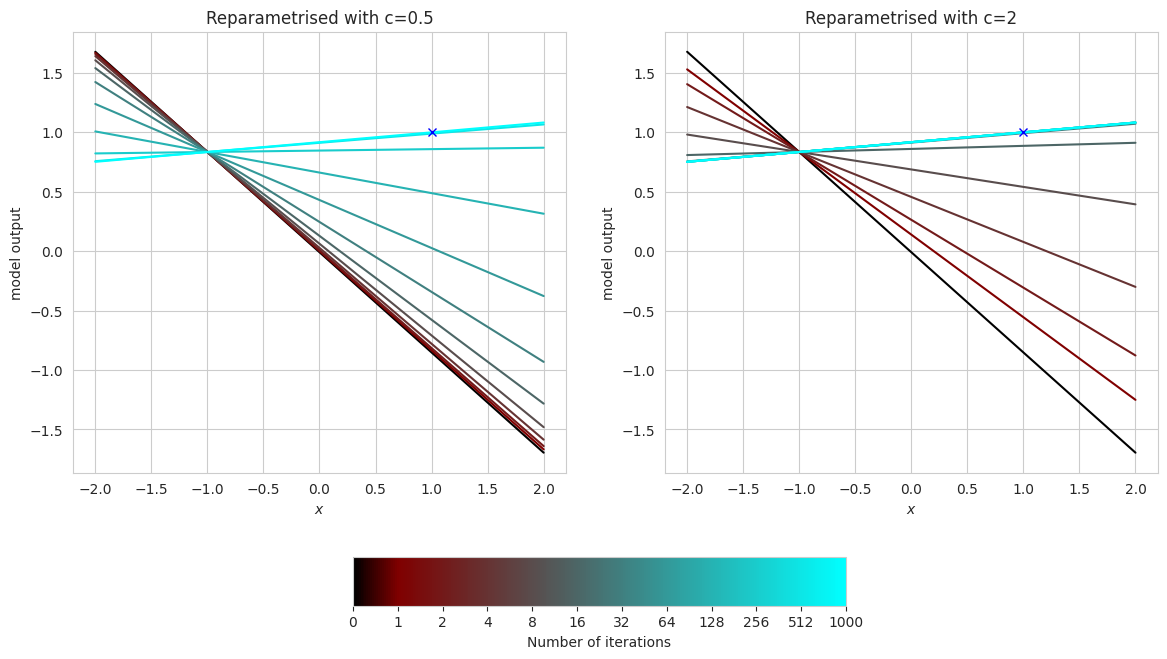

In [14]:
torch.manual_seed(1337)
lin = Linear(1, 1)

x = torch.tensor([[1.0]])
y = torch.tensor([[1.0]])

reparam1 = reparametrise_linear(lin, c=2)
results1 = gradient_steps(reparam1, x, y, x_grid, lr=0.01, iterations=1024)
print("\n")
reparam2 = reparametrise_linear(lin, c=0.5)
results2 = gradient_steps(reparam2, x, y, x_grid, lr=0.01, iterations=1024)

fig, ((ax2, ax1), (colorbarAxis, _)) = plt.subplots(2, 2, figsize=(14, 7), height_ratios=(0.9, 0.1))
_.set_axis_off()

color_mapping = lambda i: (0.5 - i/20, i/10, i/10)
ax1.plot(x_grid, results1[0], color=(0, 0, 0))
ax2.plot(x_grid, results2[0], color=(0, 0, 0))
for i in range(11):
    ax1.plot(x_grid, results1[min(1000, 2**i)], color=color_mapping(i))
    ax2.plot(x_grid, results2[min(1000, 2**i)], color=color_mapping(i))

for ax, c in (ax1, 2), (ax2, 0.5):
    ax.set_xlabel('$x$')
    ax.set_ylabel('model output')
    ax.plot(x, y, 'bx')
    ax.set_title(f"Reparametrised with c={c}")

colorbar = plt.colorbar(
    cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1),
        cmap=colors.LinearSegmentedColormap.from_list("", [(0, 0, 0)] + [color_mapping(i) for i in range(11)])),
    pad=5, shrink=0.1, cax=colorbarAxis, orientation="horizontal"
)
colorbar.set_ticks(ticks=[x/11 for x in range(12)], labels=[0]+[2**i for i in range(10)]+[1000])
colorbar.set_label("Number of iterations")

LL, BB, WW, HH = colorbar.ax.get_position().bounds
colorbar.ax.set_position([LL+0.2, BB-0.05, WW, HH])

#### Interpretation

The parameters of the model with higher $c$ learn faster (as explained in the previous task), so that model also converges faster here.

I was surprised at first that all the lines seem to go through the same $(-1, y_1)$ point, but remember that $~y_1 = -w+b$, and as shown in the previous exercise, $w$ and $b$ always receive equal updates, so $y_1$ stays constant.

# Question A.4: Reparametrization invariance in ReLU Networks




Implement a function that takes a one hidden layer ReLU network (i.e. two Linear layers with a ReLU sandwiched between them) and finds an equivalent network with different parameters that implements the same function. You can do this along the lines of [(Dinh et al, 2017)](https://arxiv.org/pdf/1703.04933.pdf).

The key observation is that the ReLU activation function satisfies $\phi(\alpha t) = \alpha \phi(t)$ for all $\alpha \neq 0$, a property called homogeneity. Thus, if we divide the weights and biases **before** the ReLU by $\alpha$, and multiply the weights after the ReLU by the same $\alpha$, overall, the network's behaviour has not changed.

Implement the `reparametrise_relu` function below. Don't forget to use `deepcopy` and `no_grad`. in multi-layer models you can use `model[i]` indexing to access the `i`-th layer. I include a basic test cell below.


## Answer A.4

Please complete the code block below.

In [17]:
from copy import deepcopy

@torch.no_grad()
def reparametrise_relu(model, alpha=2.0):
    """Reparametrises a one-hidden-layer ReLU network using the scaling method of (Dinh et al, 2017)"""
    ## step 1: copy model
    model = deepcopy(model)   # now we can't accidentally mutate the non-local one

    ## step 2: scale weights and biases in the two linear layers
    model[0].weight *= alpha
    model[0].bias *= alpha
    model[2].weight /= alpha

    return model

In [18]:
from torch.nn import ReLU, Sequential, Linear
#here is a simple test that should successfully run
torch.manual_seed(1337)
model = Sequential(Linear(1, 128), ReLU(), Linear(128, 1))
model2 = reparametrise_relu(model, alpha=2.0)
#the model should be functionally the same
assert torch.allclose(model(x_grid), model2(x_grid))
#both models should have 4 trainable parameters
assert len([p for p in model.parameters() if p.requires_grad])==4
assert len([p for p in model2.parameters() if p.requires_grad])==4

# Question A.5: Training from different initialization



A.5.1
Now create a two-layer ReLU network with 512 hidden units. Use the `reparametrise_relu` function, with $\alpha=10$, to find a functionally equivalent network. Starting from these two networks as initialization, train the networks until convergence on the new toy data provided. Interpret and explain the results (3-5 sentences).

A.5.2
Now explore the same using different optimizers. Do you see any difference in the results? (3-5 sentences) Could there exist an optimization algorithm which makes the two models converge to the same solution? (2-3 sentences)

## Answer A.5

Please complete the code cell below and add interpretation in the text cell provided.

In [ ]:
from torch.nn import ReLU, Sequential, Linear
import torch
from matplotlib import pyplot as plt

x = torch.tensor([[-1.0], [-0.0], [1.0]])
y = torch.tensor([[1.0], [-1.0], [1.0]])

torch.manual_seed(1337)
model = Sequential(Linear(1, 512), ReLU(), Linear(512, 1))

# create a reparametrized model starting from this model
reparam_model = reparametrise_relu(model, alpha=10)

# train both models until convergence (find good learning rate); plot the solution each model converged to
resultsOriginal = gradient_steps(model, x, y, x_grid, lr=0.001, iterations=2**13)
resultsReparam = gradient_steps(reparam_model, x, y, x_grid, lr=0.001, iterations=2**13)


def draw_results(resultsOriginal, resultsReparam):
    fig, ((ax1, ax2), (colorbarAxis, _)) = plt.subplots(2, 2, figsize=(14, 7), height_ratios=(0.9, 0.1))
    _.set_axis_off()

    color_mapping = lambda i: (0.5 - i/26, i/13, i/13)
    ax1.plot(x_grid, resultsOriginal[0], color=(0, 0, 0))
    ax2.plot(x_grid, resultsReparam[0], color=(0, 0, 0))
    for i in range(14):
        ax1.plot(x_grid, resultsOriginal[2**i], color=color_mapping(i))
        ax2.plot(x_grid, resultsReparam[2**i], color=color_mapping(i))

    ax1.set_title(f"Original model")
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('model output')
    ax1.plot(x, y, 'bx')

    ax2.set_title(f"Reparametrised with α=10")
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('model output')
    ax2.plot(x, y, 'bx')

    colorbar = plt.colorbar(
        cm.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=1),
            cmap=colors.LinearSegmentedColormap.from_list("", [(0, 0, 0)] + [color_mapping(i) for i in range(14)])),
        pad=5, cax=colorbarAxis, orientation="horizontal"
    )
    colorbar.set_ticks(ticks=[x/14 for x in range(15)], labels=[0]+[2**i for i in range(14)])
    colorbarAxis.tick_params(labelsize=8)
    colorbar.set_label("Number of iterations")

    LL, BB, WW, HH = colorbar.ax.get_position().bounds
    colorbar.ax.set_position([LL+0.2, BB-0.05, WW, HH])


draw_results(resultsOriginal, resultsReparam)

Very different: the one on the right still *does* converge, but its left-tail is insane (the y-axis is in $10^6$), and the loss at the training points is also much worse (though it's hard to tell from this graph alone). So even though it stabilises, it's shooting past the global optimum. So I experimented with lowering the learning rate for the reparametrised model, and:

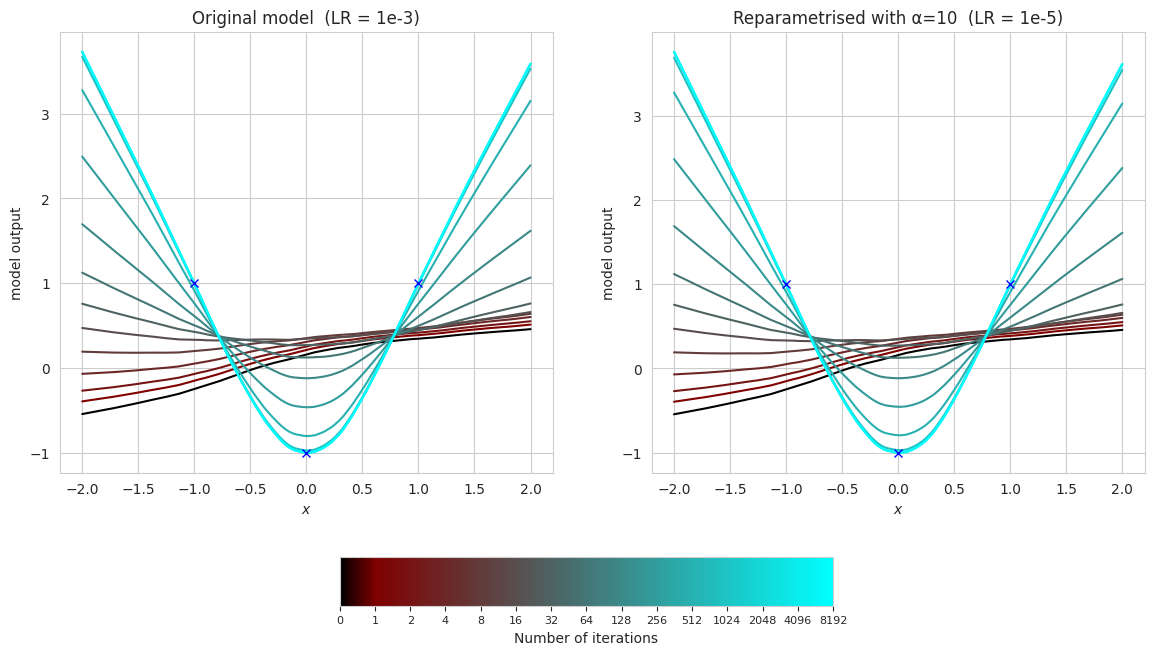

In [27]:
torch.manual_seed(1337)
model = Sequential(Linear(1, 512), ReLU(), Linear(512, 1))
reparam_model = reparametrise_relu(model, alpha=10)

resultsOriginal = gradient_steps(model, x, y, x_grid, lr=0.001, iterations=2**13)
resultsReparam = gradient_steps(reparam_model, x, y, x_grid, lr=0.00001, iterations=2**13)

draw_results(resultsOriginal, resultsReparam)

Dividing the learning rate by 100 seems *exactly* right. This might suggest that reparametrising with $\alpha$ multiplies the learning rate by $\alpha^2$.

What if, instead of having to manually give them different learning rates, we use Adam?

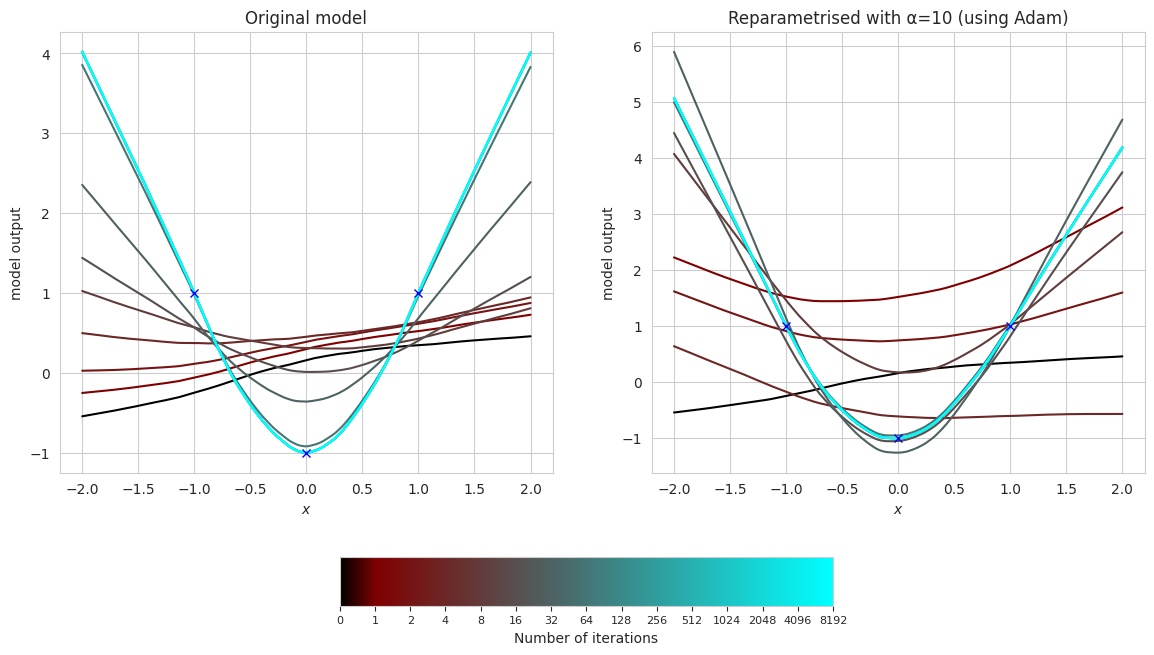

In [23]:
torch.manual_seed(1337)
model = Sequential(Linear(1, 512), ReLU(), Linear(512, 1))

# create a reparametrized model starting from this model
reparam_model = reparametrise_relu(model, alpha=10)

# train both models until convergence (find good learning rate); plot the solution each model converged to
resultsOriginal = gradient_steps(model, x, y, x_grid, lr=0.001, iterations=2**13, optimizer=torch.optim.Adam)
resultsReparam = gradient_steps(reparam_model, x, y, x_grid, lr=0.001, iterations=2**13, optimizer=torch.optim.Adam)
draw_results(resultsOriginal, resultsReparam)

Pretty similar - only some minor differences, and these are mostly outside the training distribution.

# Revisiting the take-aways

Hopefully, if you followed along this exercise, you gained some fresh insights into gradient-based learning and neural networks. Please take a moment to think about the take-home messages from this exercise, and see if you can back these up with your findings from the work above:

1. In neural networks, the same function can be represented by several different settings of the parameters. This is called reparametrization-invariance.
2. Differently parametrized neural networks behave differently under gradient descent, and this difference may lead to qualitatively different solutions.
3. Initialization of parameters is crucially important. Starting from different initialization (even if it's starting from the same function) can lead to qualitatively different solutions, too.

# Section A Writeup checklist

Please compile your findings into a writeup. Please make sure you include:
* 1 figure with the linear models with legends
* summary paragraph describing the linear model findings
* derivation of gradient descent behaviour in linear model (using an extra page is allowed)
* 1 figure with the ReLU results with legends
* a qualitative description of the ReLU findings
* an explanation/interpretation of why we see what we see
* a comment on different optimizers